# Q-Learning vs Sarsa in Cliff Walking

In [101]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import defaultdict

In [102]:
class GridWorld:
    terrain_color = dict(
        normal = [128, 128, 128],
        player = [255, 255, 0],
        cliff = [0, 0, 255],
        objective = [255, 0, 0],
    )

    def __init__(self):
        self.grid = self.terrain_color['normal'] * np.ones((4, 12, 3))
        self.grid[-1, 0] = self.terrain_color['player']
        self.grid[-1, 1:11] = self.terrain_color['cliff']
        self.grid[-1, -1] = self.terrain_color['objective']
        self._draw_grid()

    def _draw_grid(self):
        self.fig, self.ax = plt.subplots(figsize=(12, 4))
        self.ax.grid(which='minor')
        for idx in range(12 * 4):
            self.ax.text(
                *self._id_to_position(idx)[::-1],
                f'{idx} / {self._id_to_position(idx)}',
                horizontalalignment='center'
            )
        self.ax.imshow(self.grid.astype(np.uint8), cmap='terrain')
        self.ax.set_xticks(np.arange(12))
        self.ax.set_xticks(np.arange(12) - 0.5, minor=True)
        self.ax.set_yticks(np.arange(4))
        self.ax.set_yticks(np.arange(4) - 0.5, minor=True)

    def show_grid(self, Q):
        self.fig, self.ax = plt.subplots(figsize=(16, 8))
        self.ax.grid(which='minor')        
        for idx in range(12 * 4):
            self.ax.text(
                *self._id_to_position(idx)[::-1],
                '\n'.join(f'{k:.2f}' for k in Q[idx]),
                horizontalalignment='center',
                verticalalignment='center',
                fontsize=12
            )        
        self.ax.imshow(self.grid.astype(np.uint8), cmap='terrain')
        self.ax.set_xticks(np.arange(12))
        self.ax.set_xticks(np.arange(12) - 0.5, minor=True)
        self.ax.set_yticks(np.arange(4))
        self.ax.set_yticks(np.arange(4) - 0.5, minor=True)
        self.ax.set_title('up, down, right, left')

    def _id_to_position(self, idx):
        return (idx // 12), (idx % 12) # (row, col)
    
    def _position_to_id(self, pos):
        return pos[0] * 12 + pos[1]
    
    def reset(self):
        self.player = (3, 0)
        return self._position_to_id(self.player)
    
    def step(self, action):
        # UP = 0, DOWN = 1, RIGHT = 2, LEFT = 3
        # player's coordinate: (row, col)
        if action == 0 and self.player[0] > 0:
            self.player = (self.player[0] - 1, self.player[1])
        if action == 1 and self.player[0] < 3:
            self.player = (self.player[0] + 1, self.player[1])
        if action == 2 and self.player[1] < 11:
            self.player = (self.player[0], self.player[1] + 1)
        if action == 3 and self.player[1] > 0:
            self.player = (self.player[0], self.player[1] - 1)
        if all(self.grid[self.player] == self.terrain_color['cliff']):
            reward = -100
            done = True
        elif all(self.grid[self.player] == self.terrain_color['objective']):
            reward = 0
            done = True
        else:
            reward = -1
            done = False
        return self._position_to_id(self.player), reward, done

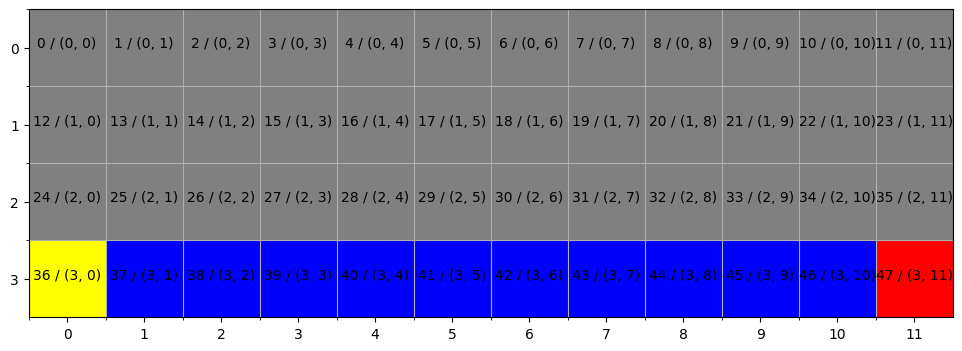

In [103]:
env = GridWorld()
env

In [104]:
UP = 0
DOWN = 1
RIGHT = 2
LEFT = 3
actions = ['UP', 'DOWN', 'RIGHT', 'LEFT']

In [105]:
num_states = 4 * 12
num_actions = 4

In [106]:
def pi(Q, state, e=0.1):
    if np.random.random() < e:
        return np.random.choice(4)
    else:
        return np.argmax(Q[state])

In [107]:
num_episodes = 500
gamma = 0.9
alpha = 0.5
epsilon = 0.1

In [108]:
def Q_Learning():
    Q = defaultdict(lambda: np.zeros(num_actions))
    for _ in range(num_episodes):
        s = env.reset()
        done = False
        while not done:
            a = pi(Q, s, epsilon)
            s_, r, done = env.step(a)
            Q[s][a] += alpha * (r + gamma * np.max(Q[s_]) - Q[s][a])
            s = s_
    return Q

In [109]:
def Sarsa():
    Q = defaultdict(lambda: np.zeros(num_actions))
    for _ in range(num_episodes):
        s = env.reset()
        done = False
        a = pi(Q, s, epsilon)
        while not done:           
            s_, r, done = env.step(a)
            a_ = pi(Q, s_, epsilon)
            Q[s][a] += alpha * (r + gamma * Q[s_][a_] - Q[s][a])
            s = s_
            a = a_
    return Q

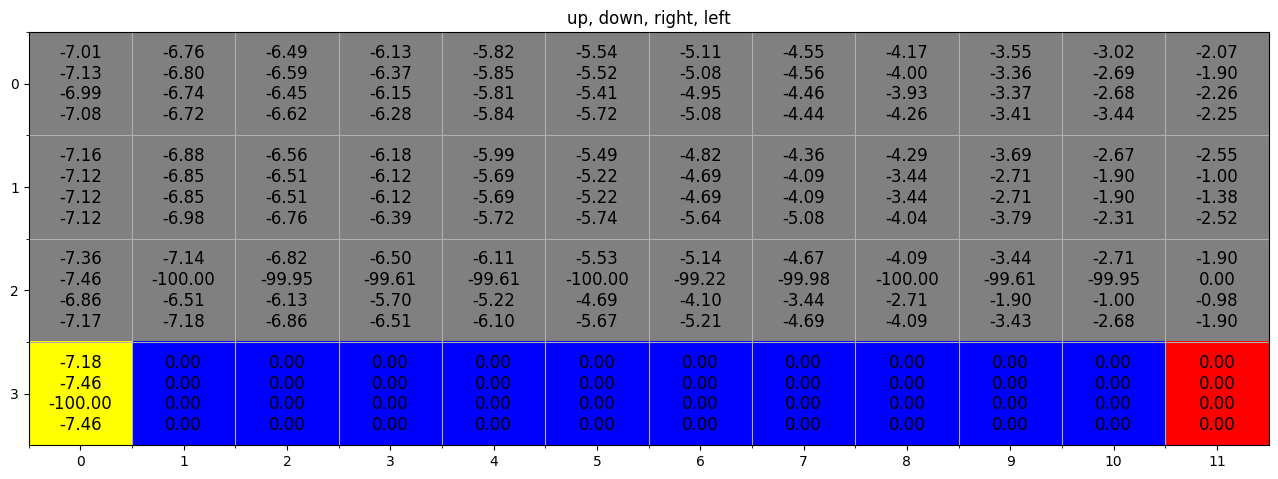

In [110]:
Q = Q_Learning()
env.show_grid(Q)

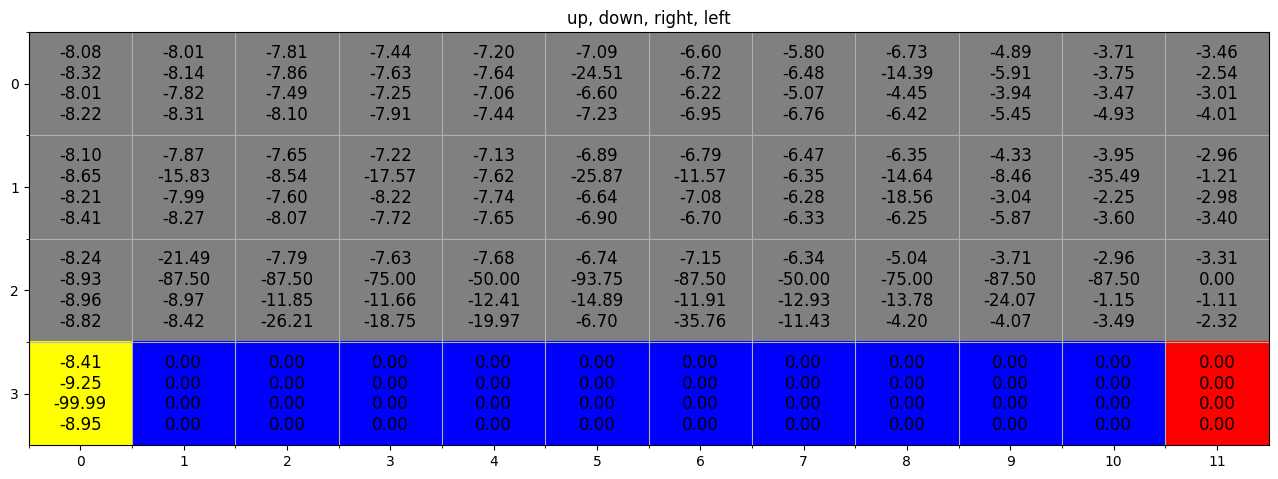

In [111]:
Q = Sarsa()
env.show_grid(Q)